<a href="https://colab.research.google.com/github/sandaruwanWGMA/Text-Sequence-Prediction-Shakespearean-Sonnets/blob/main/Text_Sequence_Prediction_Shakespearean_Sonnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Sequence Prediction: Shakespearean Sonnets

In this phase of the project, the focus shifts to predicting the subsequent word in a text sequence. Leveraging the principles covered thus far, I am tasked with crafting a model tailored for this predictive task. The training dataset for this endeavor is sourced from the captivating sonnets of William Shakespeare.

To kickstart this endeavor, I am in the process of implementing the predictive model, drawing insights from the techniques introduced during the course of the week. The model's architecture will be designed to effectively anticipate the next word in a given sequence, showcasing the convergence of theory and practical application.

In tandem with model creation, the development of pivotal helper functions is underway. These functions are crafted to pre-process the dataset, ensuring it aligns seamlessly with the model's requirements. Data organization and formatting are key aspects addressed by these helper functions, laying a solid foundation for a successful training phase.

As I immerse myself in this segment of the project, the integration of predictive modeling, meticulous training procedures, and thoughtful data pre-processing takes center stage. The ultimate goal is to fine-tune the model to predict the next word with precision, creating a captivating fusion of language and machine learning within the realm of Shakespearean sonnets.

*   List item
*   List item



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 111MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Fit the Tokenizer to the corpus and save the total number of words.

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

When converting the text into sequences you can use the `texts_to_sequences` method as you have done throughout this course.

In the next graded function you will need to process this corpus one line at a time. Given this, it is important to keep in mind that the way you are feeding the data unto this method affects the result. Check the following example to make this clearer.

The first example of the corpus is a string and looks like this:

In [5]:
corpus[0]

'from fairest creatures we desire increase,'

If we pass this text directly into the `texts_to_sequences` method, an unexpected result will occur. The reason lies in the fact that `texts_to_sequences` expects a list of texts as input, but when provided with a single string, it interprets each character as an individual text unit. Consequently, the method returns a sequence of word indices for each character rather than for the entire sentence.

To address this, it's crucial to wrap the text in a list before passing it to `texts_to_sequences`. This ensures that the method interprets the entire string as a single text sequence, facilitating the correct conversion to a sequence of word indices. This small adjustment is essential to obtaining the intended result when processing text through the tokenizer.

In [6]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

The error occurred because the `texts_to_sequences` method expects a list, and in my initial implementation, I inadvertently provided a string. While a string is iterable in Python, it resulted in obtaining the word index for each individual character rather than for the entire sequence.

To rectify this, it's crucial to encapsulate the example within a list before passing it to the `texts_to_sequences` method. This ensures that the method interprets the input as a single sequence rather than a sequence of characters. The corrected approach involves wrapping the example in square brackets to explicitly denote it as a list, allowing for accurate processing and conversion to sequences.

In [7]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence you need to explicitly get the first item in the list like this:

In [8]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

In the ongoing task of refining our language model, I've completed the `n_gram_seqs` function, a critical component in the pre-processing pipeline. This function takes a fitted tokenizer and a corpus, represented as a list of strings, as inputs. Its primary objective is to generate n-gram sequences for each line within the corpus.

To achieve this, the function iterates through each line, converting it into a sequence of word indices using the previously fitted tokenizer. Subsequently, it constructs n-gram sequences by sliding a window of size `n` through the sequence. These n-gram sequences are then appended to a list, forming the basis of our model's training data.

By encapsulating the logic for n-gram sequence generation within this function, we streamline the pre-processing phase, ensuring that our model receives input data in a format conducive to effective learning. This meticulous approach sets the stage for training a language model adept at predicting the next word in Shakespeare's sonnets.

In [9]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]

      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]

        input_sequences.append(n_gram_sequence)
    ### END CODE HERE

    return input_sequences

In [10]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

**Expected Output:**

```
n_gram sequences for first example look like this:

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]
```

In [11]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

**Expected Output:**

```
n_gram sequences for next 3 examples look like this:

[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]
```

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [12]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences:

In [13]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences
    ### END CODE HERE

In [14]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

**Expected Output:**

```
array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)
```

In [15]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [16]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


**Expected Output:**

```
padded corpus has shape: (15462, 11)
```

## Split the data into features and labels

As I progress in my project, a crucial step before feeding the data into the neural network involves splitting it into features and labels. To accomplish this, I've implemented the `features_and_labels` function, which plays a pivotal role in shaping the input data for effective model training.

This function takes the padded n-gram sequences as input and is designed to return a tuple containing the features and the corresponding one-hot encoded labels. Notably, the features consist of the padded n-gram sequences with the last word removed, while the labels represent the removed word.

An additional parameter in this function is the total number of words in the corpus. This parameter proves vital during the one-hot encoding process, ensuring that every word in the corpus is appropriately represented in the categorical labels. For a refresher on the `to_categorical` function, I referred to the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical), ensuring precise implementation.

With the `features_and_labels` function in place, the data is poised for seamless integration into the neural network, aligning with the overarching goal of training a language model adept at predicting the next word in Shakespeare's sonnets.

In [17]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [18]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,  34],
       [  0,   0,  34, 417],
       [  0,  34, 417, 877],
       [ 34, 417, 877, 166],
       [417, 877, 166, 213]], dtype=int32)

In [19]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


**Expected Output:**

```
features have shape: (15462, 10)
labels have shape: (15462, 3211)
```

## Create the model

In crafting the neural network for text sequence prediction in Shakespeare's sonnets, I've opted for a concise architecture:

- **Embedding Layer:** Initiated with an `output_dim` of 100 to capture word representations.
  
- **Bidirectional LSTM:** Leveraging the bidirectional nature of LSTM layers for enhanced sequential context.

- **Output Layer:** Featuring the same units as total words, equipped with softmax activation for next-word prediction.

This streamlined model, limited to two layers, balances complexity for optimal performance, targeting an accuracy of 80% or higher. The iterative refinement process remains pivotal in achieving accurate predictions within the sonnet context.

In [20]:
# GRADED FUNCTION: create_model
import tensorflow as tf
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

    model.add(Bidirectional(tf.keras.layers.GRU(64))),
    model.add(Dense(total_words*6, activation='relu'))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [21]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 24s 40ms/step - loss: 6.7447 - accuracy: 0.0305
Epoch 2/50
484/484 [==============================] - 13s 28ms/step - loss: 6.1976 - accuracy: 0.0565
Epoch 3/50
484/484 [==============================] - 13s 27ms/step - loss: 5.6419 - accuracy: 0.0733
Epoch 4/50
484/484 [==============================] - 14s 28ms/step - loss: 5.0441 - accuracy: 0.1002
Epoch 5/50
484/484 [==============================] - 13s 27ms/step - loss: 4.3866 - accuracy: 0.1407
Epoch 6/50
484/484 [==============================] - 14s 29ms/step - loss: 3.6399 - accuracy: 0.2121
Epoch 7/50
484/484 [==============================] - 13s 27ms/step - loss: 2.8364 - accuracy: 0.3398
Epoch 8/50
484/484 [==============================] - 13s 26ms/step - loss: 2.1225 - accuracy: 0.4822
Epoch 9/50
484/484 [==============================] - 13s 26ms/step - loss: 1.5760 - accuracy: 0.6065
Epoch 10/50
484/484 [==============================] - 13s 26ms/step - loss: 1.215

**To pass this assignment, your model should achieve a training accuracy of at least 80%**. If your model didn't achieve this threshold, try training again with a different model architecture, consider increasing the number of unit in your `LSTM` layer.

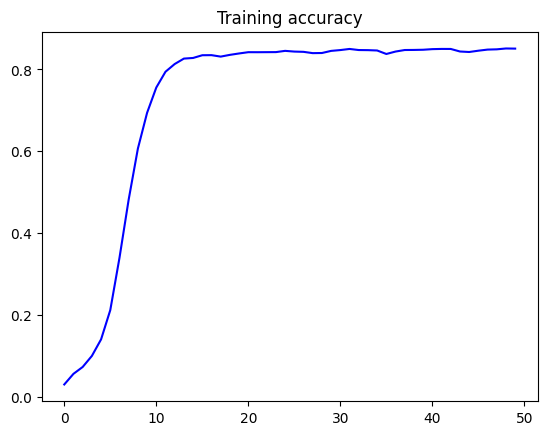

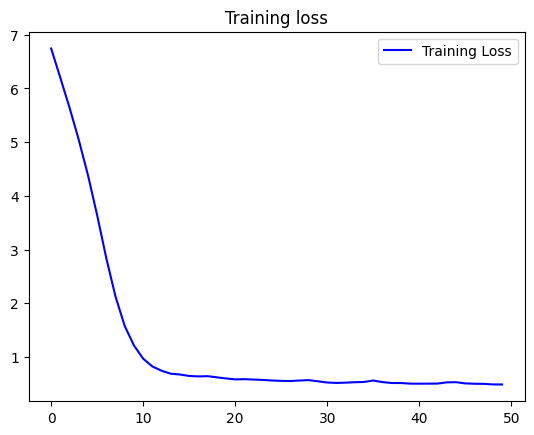

In [22]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [23]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## See your model in action

Having navigated through the various stages of model development, it's an exciting moment to witness the culmination of efforts. Running the cell below unveils the model's capability to generate the next 100 words based on a given seed text.

Post-submission, I'm intrigued to explore further experimentation, adjusting training epochs to gauge their impact on text coherency. Additionally, varying the seed text promises diverse and captivating outcomes, offering a glimpse into the model's adaptability to different linguistic contexts.

This marks a dynamic phase in the project, as the neural network transforms from a trained model to a creative text generator, showcasing the intricacies of language modeled after Shakespeare's sonnets.

In [24]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my best acquainted beside behind you to is't in thee 'fair kind and thee of thee alas i have spent thee more in of thee receiving i in thee i am of thee 'fair in doubt wooing on that night doth latch hue thee is't not compared with me that i am not so wooing me alone of thee i feed on thee i derive sought sought is't not thee again and i thee prove thee more in in me more receiving in you can be the art of more of you of me untrue arising is't not disdains the
